## Standard Analysis
 

In [1]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report


import skimage.io
from scipy.spatial.distance import cdist

import sys
#sys.path.insert(0,'../')
from helper import classification_tools as ct
from helper import visualize as vis

%matplotlib inline

In [2]:
# fc1 features saved from the previous step
fc1_path = Path('data','features','VGG16_fc1_features_std.pickle')
assert fc1_path.is_file()

# label encoder model which converts string labels to integers.
le_path = Path('models','label_encoder.pickle')
assert le_path.is_file()

# load the data and label encoder into memory
with open(fc1_path, 'rb') as f:
    data = pickle.load(f)

with open(le_path, 'rb') as f:
    le = pickle.load(f)

In [3]:
files = data['filename']  # file paths to each image
fc1 = data['features']  # array containing fc1 features for each file
labels = data['labels']  # string labels for each image
y_gt = le.transform(labels)  # integer labels for each image

## Dimension reduction


In [4]:
pca_n = PCA(svd_solver='full')
x_pca_ = pca_n.fit_transform(fc1)

var_ = pca_n.explained_variance_ratio_.cumsum()

variance preserved by 50 components: 0.735


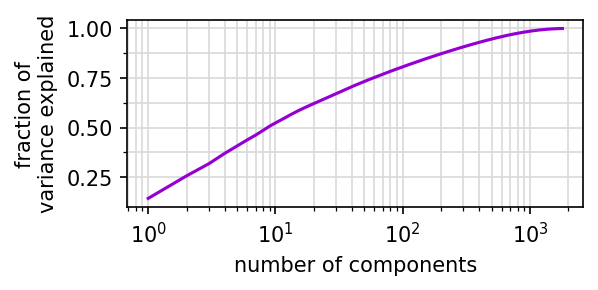

In [5]:
fig, ax = plt.subplots(figsize=(4,2),dpi=150,)
ax.grid('on', which='both', color=np.ones(3)*0.85)
ax.plot(range(1,len(var_)+1), var_, color='darkviolet')
ax.set_xscale('log')
ax.set_xlabel('number of components')
ax.set_ylabel('fraction of\nvariance explained')

yt=np.linspace(1/4, 1, 4)
ytm = [np.mean([yt[i], yt[i+1]]) for i in range(len(yt)-1)]
ax.set_yticks(ytm, minor=True)


fig.tight_layout()
fig.savefig(Path('Figures','PCA_Var.png'), bbox_inches='tight')
print('variance preserved by 50 components: {:.3f}'.format(var_[50]))

## T-SNE Visualization
 

In [6]:
pca = PCA(n_components=50, svd_solver='full', whiten=True)
pca_nw = PCA(n_components=50, svd_solver='full', whiten=False)
x = pca.fit_transform(fc1)
x_nw = pca_nw.fit_transform(fc1)


In [7]:
tsne = TSNE(n_components=2, random_state=12214)
tsne_w = TSNE(n_components=2, random_state=654753)
x_nw_tsne = tsne.fit_transform(x_nw)
x_w_tsne = tsne_w.fit_transform(x)

C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


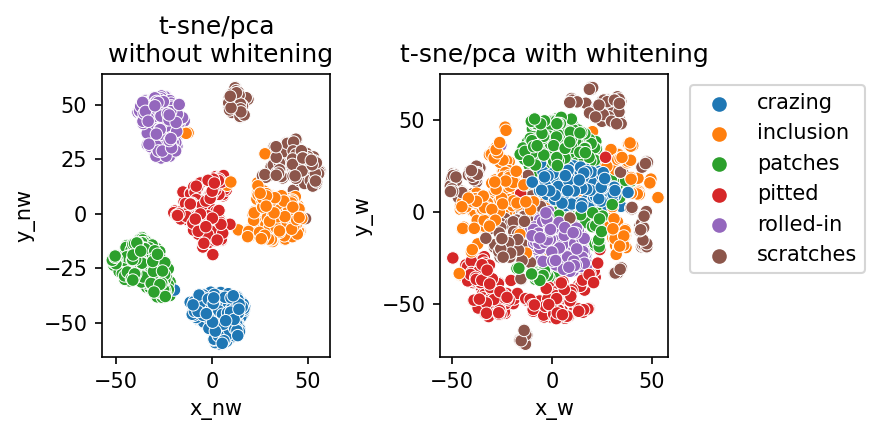

In [8]:
labels_ordered = le.inverse_transform(range(len(le.mapper)))
df = pd.DataFrame({'files': files,
                   'x_nw':x_nw_tsne[:,0],
                   'y_nw':x_nw_tsne[:,1],
                   'x_w': x_w_tsne[:,0],
                  'y_w': x_w_tsne[:,1],
                   'labels': labels,
                  },
                  index=files)

fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=150)
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered,  ax=ax[0])
sns.scatterplot(data=df, x='x_w', y='y_w', hue='labels', hue_order=labels_ordered, ax=ax[1])
ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('t-sne/pca\n without whitening')
ax[1].set_title('t-sne/pca with whitening')
fig.tight_layout()
plt.show()


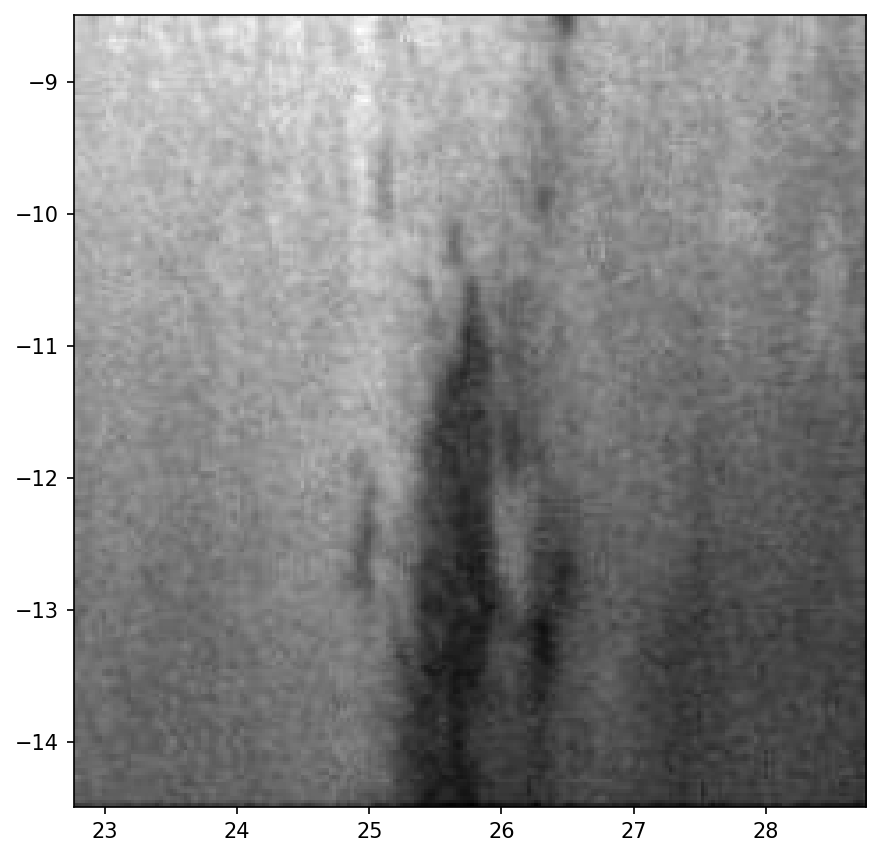

In [9]:
vis.pano_plot(x_nw_tsne[:,0], x_nw_tsne[:,1], files)


In [10]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=2149673460)
kmeans.fit(x)
labels_unmatched = kmeans.labels_  # labels from k-means are arbitrary and must be mapped to the format of the ground truth labels
y_pred = ct.label_matcher(labels_unmatched, y_gt,)  # this function matches the labels so we can compare directly
print('inertia: {:.2f}'.format(kmeans.inertia_))

inertia: 80459.92


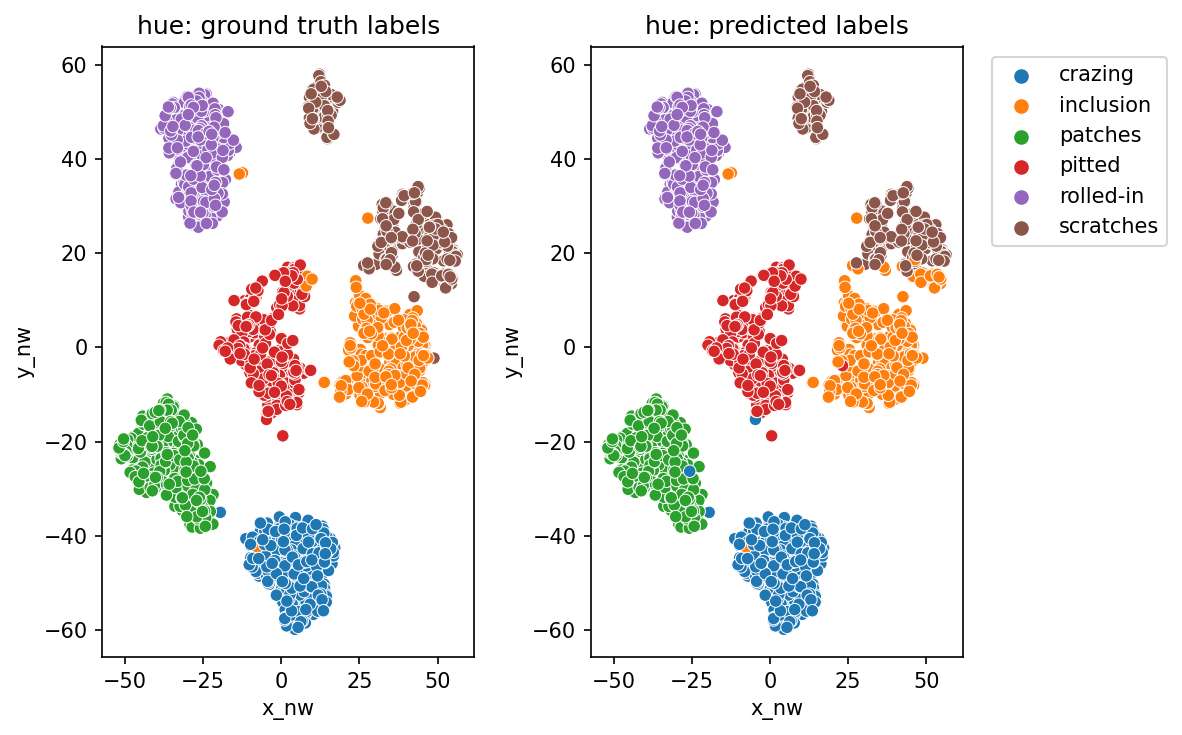

In [11]:
y_pred_str = le.inverse_transform(y_pred)
df['y_pred_labels'] = pd.Series(y_pred_str, index=files)

fig, ax = plt.subplots(1,2, figsize=(8,5), dpi=150)


sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='labels', hue_order=labels_ordered, ax=ax[0]) # ground truth labels
sns.scatterplot(data=df, x='x_nw', y='y_nw', hue='y_pred_labels', hue_order=labels_ordered, ax=ax[1]) # predicted labels

ax[0].get_legend().remove()
ax[1].legend(bbox_to_anchor=(1.05,1))
ax[0].set_title('hue: ground truth labels')
ax[1].set_title('hue: predicted labels')
fig.tight_layout()
plt.show()

In [12]:
%load_ext autoreload
%autoreload 2
from helper import visualize as vis

C:\Users\91800\Documents\MTP\helper\visualize.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for i in range(n)], minor=False, fontsize=fs)
C:\Users\91800\Documents\MTP\helper\visualize.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for i in range(n)], minor=False, fontsize=fs)


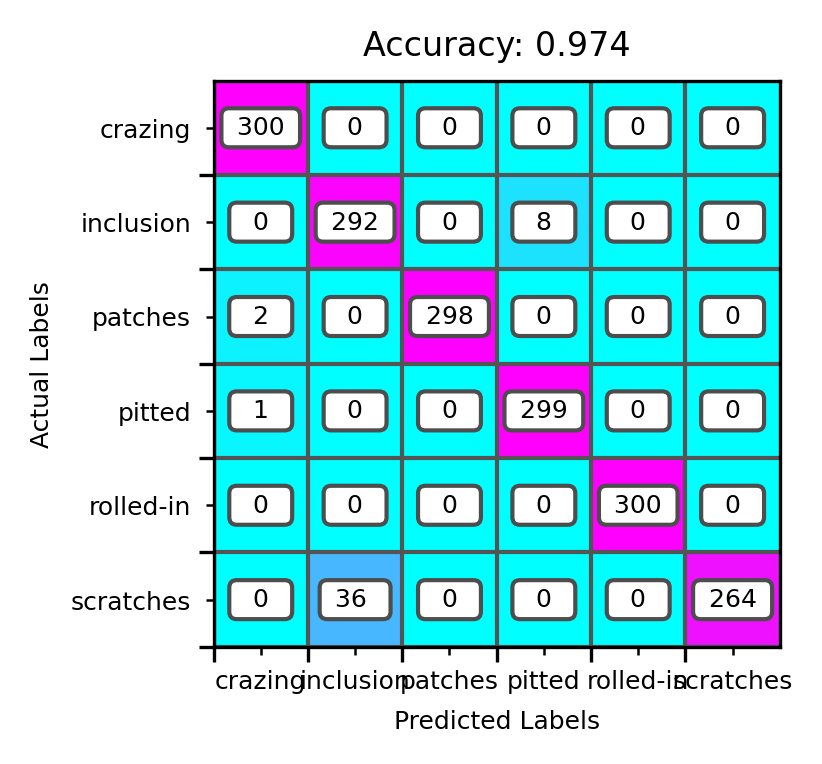

Accuracy: 0.974


In [13]:
# The confusion matrix allows us to evaluate the performance
CM = confusion_matrix(y_gt, y_pred)
vis.pretty_cm(CM, labels_ordered)
print('Accuracy: {:.3f}'.format(CM.trace()/CM.sum()))

In [16]:
# This takes a couple minutes to run, be patient!
use_cache=True
std_10run_cache_path = Path('.neu_cache','st_10runresults.pickle')

if not use_cache or not std_10run_cache_path.is_file():
    rs = np.random.RandomState(seed=987654321)
    accuracies = np.zeros(10)
    for i, seed in enumerate(rs.randint(2**16, size=10)):
        kmeans_ = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=seed)
        kmeans_.fit(x)
        labels_unmatched_ = kmeans_.labels_
        y_pred_ = ct.label_matcher(labels_unmatched_, y_gt)
        acc = (y_pred_ == y_gt).sum()/len(y_gt)
        accuracies[i] = acc
    
    with open(std_10run_cache_path, 'wb') as f:
        pickle.dump({'accuracies':accuracies}, f)
else:
    with open(std_10run_cache_path, 'rb') as f:
        results_ = pickle.load(f)
        accuracies = results_['accuracies']

print(accuracies)


[0.98555556 0.99277778 0.99222222 0.99166667 0.97333333 0.97555556
 0.97833333 0.99111111 0.99222222 0.99055556]


In [17]:
print('10 runs:\n\tavg: {:.4f}\n\tstd: {:.4},\n\tmin: {:.4f}'.format(accuracies.mean(), np.std(accuracies), accuracies.min()))


10 runs:
	avg: 0.9863
	std: 0.007278,
	min: 0.9733


In [18]:
print(classification_report(y_gt, y_pred, target_names=labels_ordered, digits=3))


              precision    recall  f1-score   support

     crazing      0.990     1.000     0.995       300
   inclusion      0.890     0.973     0.930       300
     patches      1.000     0.993     0.997       300
      pitted      0.974     0.997     0.985       300
   rolled-in      1.000     1.000     1.000       300
   scratches      1.000     0.880     0.936       300

    accuracy                          0.974      1800
   macro avg      0.976     0.974     0.974      1800
weighted avg      0.976     0.974     0.974      1800



In [19]:
kmeans_nw = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=13)
kmeans_nw.fit(x_nw)
labels_unmatched_nw = kmeans_nw.labels_  # labels from k-means are arbitrary and must be mapped to the format of the ground truth labels
y_pred_nw = ct.label_matcher(labels_unmatched_nw, y_gt,)  # this function matches the labels so we can compare directly

C:\Users\91800\Documents\MTP\helper\visualize.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for i in range(n)], minor=False, fontsize=fs)
C:\Users\91800\Documents\MTP\helper\visualize.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for i in range(n)], minor=False, fontsize=fs)


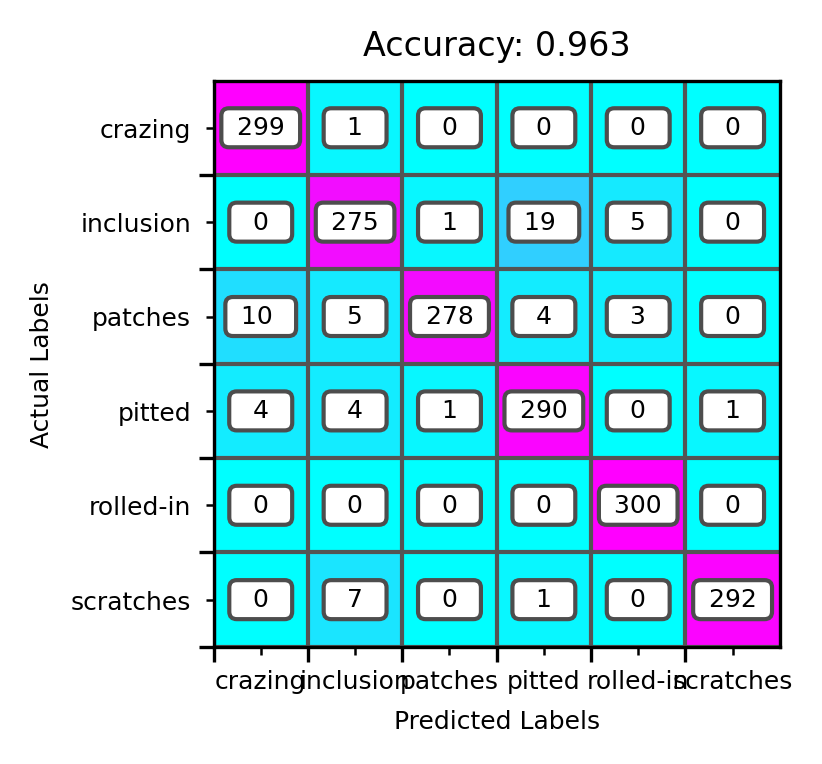

              precision    recall  f1-score   support

     crazing      0.955     0.997     0.976       300
   inclusion      0.942     0.917     0.929       300
     patches      0.993     0.927     0.959       300
      pitted      0.924     0.967     0.945       300
   rolled-in      0.974     1.000     0.987       300
   scratches      0.997     0.973     0.985       300

    accuracy                          0.963      1800
   macro avg      0.964     0.963     0.963      1800
weighted avg      0.964     0.963     0.963      1800



In [20]:
cm_nw = confusion_matrix(y_gt, y_pred_nw)
vis.pretty_cm(cm_nw, labelnames=labels_ordered)

print(classification_report(y_gt, y_pred_nw, target_names=labels_ordered, digits=3))

In [62]:
# from the t-sne plot, the two Sc clusters can separate based on their y-value 
# y = -10 perfectly separates the clusters

Sc_label = le.transform(['pitted'])[0]
Scgroup1 = np.logical_and(x_nw_tsne[:,1] < -10, 
                          y_gt==Sc_label)
Scgroup2 = np.logical_and(x_nw_tsne[:,1] > -10, 
                          y_gt==Sc_label)

In [64]:
# to get the 'most typical' image from each cluster, we can select the
# point that is closest to the cluster centroid
x1_Sc1 = x_nw_tsne[Scgroup1]
x1_Sc2 = x_nw_tsne[Scgroup2]

i1 = cdist(x1_Sc1, 
        np.mean(x1_Sc1, axis=0)[np.newaxis, :]).argmin()
i2 = cdist(x1_Sc2, 
        np.mean(x1_Sc2, axis=0)[np.newaxis, :]).argmin()

In [65]:
labarray = np.asarray(labels)
filearray = np.asarray(files)

group1files = filearray[Scgroup1]
group2files = filearray[Scgroup2]

file1 = group1files[i1]
file2 = group2files[i2]

im1 = skimage.io.imread(file1)
im2 = skimage.io.imread(file2)

C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


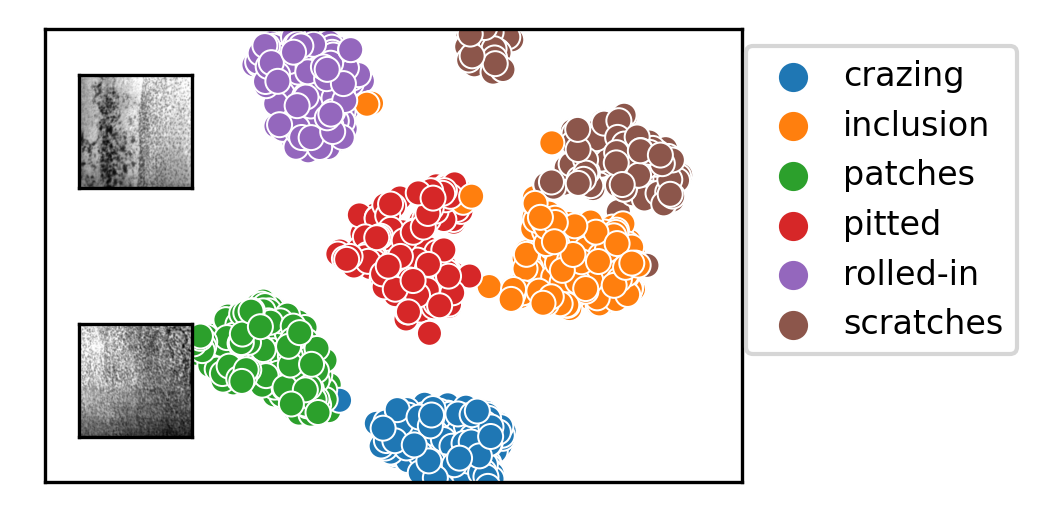

In [67]:
fig, ax  = plt.subplots(figsize=(3,2), dpi=300, facecolor='w')
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], 
                 hue=labels, hue_order=le.labels_ordered, ax=ax)
ax.axis([-85,70,-55,55])
l1 = ax.legend(loc='upper center', ncol=1,
                bbox_to_anchor=(1.2,1), columnspacing=0.5, fontsize=(8), handletextpad=0.5)

ia1 = ax.inset_axes([0.005,0.1,0.25,0.25])
ia1.set_xticks([])
ia1.set_yticks([])
ia1.axis([0,1,0,1])
ia1.imshow(im1, cmap='gray', extent=(0,1,0,1))

ia2 = ax.inset_axes([0.005,0.65,0.25,0.25])
ia2.axis([0,1,0,1])
ia2.set_xticks([])
ia2.set_yticks([])
ia2.imshow(im2, extent=(0,1,0,1), cmap='gray')
# ax.plot(x1_Sc1[i1,0], x1_Sc1[i1,1], 'kd')
# ax.plot(x1_Sc2[i2,0], x1_Sc2[i2,1], 'ks')
ax.set_xticks([])
ax.set_yticks([])
#fig.tight_layout()

fig_path = Path('Figures')
fig.savefig(fig_path / 'tsne_pitted_inlay.png', bbox_inches='tight')

plt.show()

C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


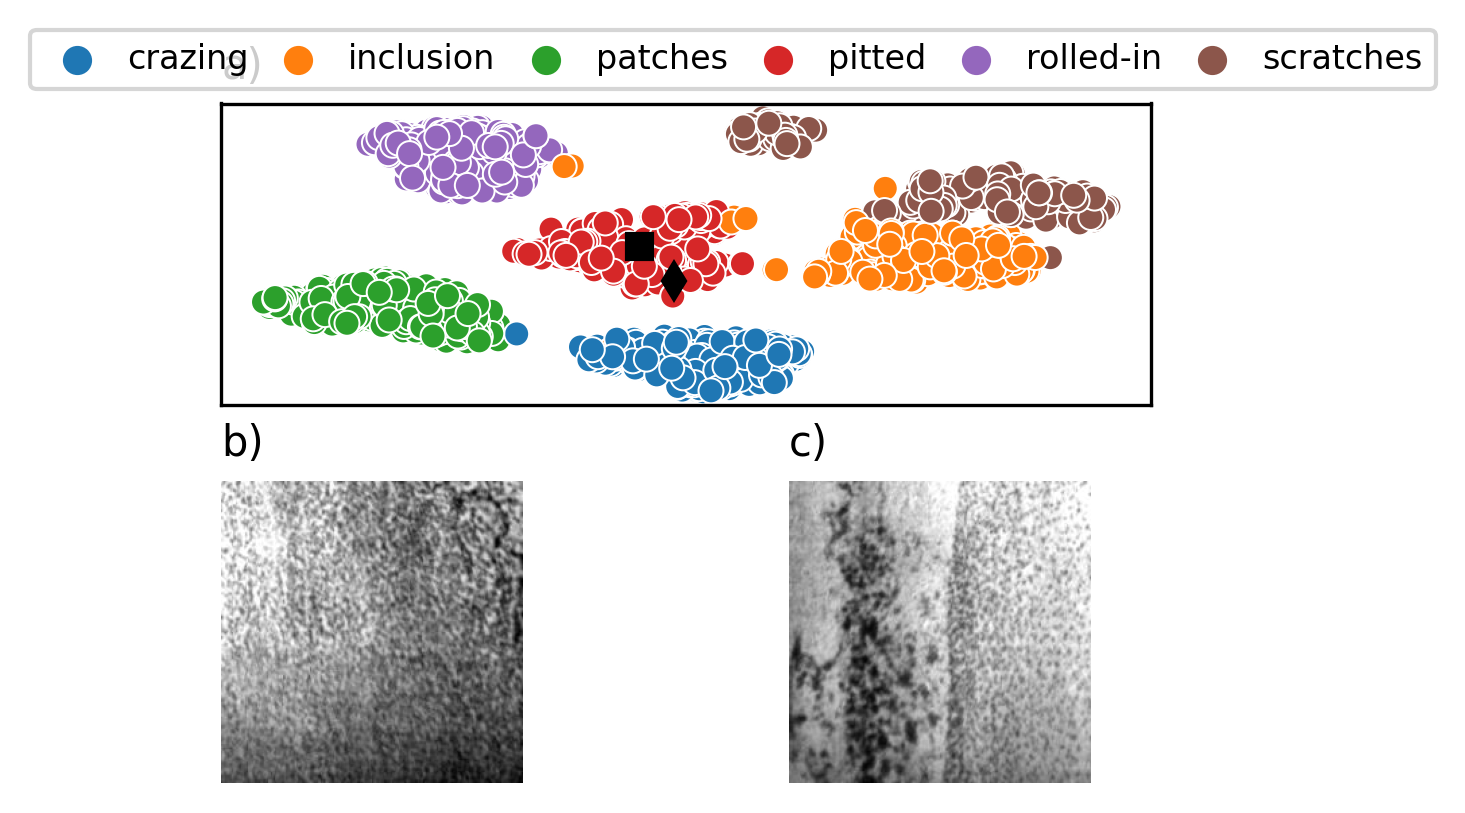

In [68]:
fig = plt.figure(figsize=(4,3), dpi=300)
gs = gridspec.GridSpec(nrows=2, ncols=2, hspace=0.25)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], 
                 hue=labels, hue_order=le.labels_ordered, ax=ax1)
l1 = ax1.legend(loc='upper center', ncol=6,
                bbox_to_anchor=(0.55,1.3), columnspacing=0.5, fontsize=(8), handletextpad=0.5)

ax1.plot(x1_Sc1[i1,0], x1_Sc1[i1,1], 'kd')
ax1.plot(x1_Sc2[i2,0], x1_Sc2[i2,1], 'ks')

ax1.set_xticks([])
ax1.set_yticks([])


ax2.imshow(im1, cmap='gray', extent=(0,1,0,1))
ax3.imshow(im2, cmap='gray', extent=(0,1,0,1))

bb = ax1.get_position()
ax2.set_position((0.125, *ax2.get_position().bounds[1:]))

ax2.axis('off')
ax3.axis('off')


ax1.set_title('a)', loc='left', fontsize=10)
ax2.set_title('b)', loc='left', fontsize=10)
ax3.set_title('c)', loc='left', fontsize=10)
#fig.tight_layout()
fig_path = Path('Figures')
fig.savefig(fig_path / 'tsne_pitted.png', bbox_inches='tight')

In [69]:
seed = 1844281023
kmeans_ = KMeans(n_clusters=7, init='k-means++', n_init=500,random_state=seed)
kmeans_.fit(x)
labels_unmatched_ = kmeans_.labels_
y_pred_ = ct.label_matcher(labels_unmatched_, y_gt)

In [70]:
strlabels = ct.label_matcher_multicluster(kmeans_.labels_, y_gt, le)


In [71]:
colors = np.concatenate((sns.color_palette()[:5], sns.color_palette()[5:6], sns.color_palette('bright')[5:6]), axis=0)


C:\Users\91800\anaconda3\envs\MTP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


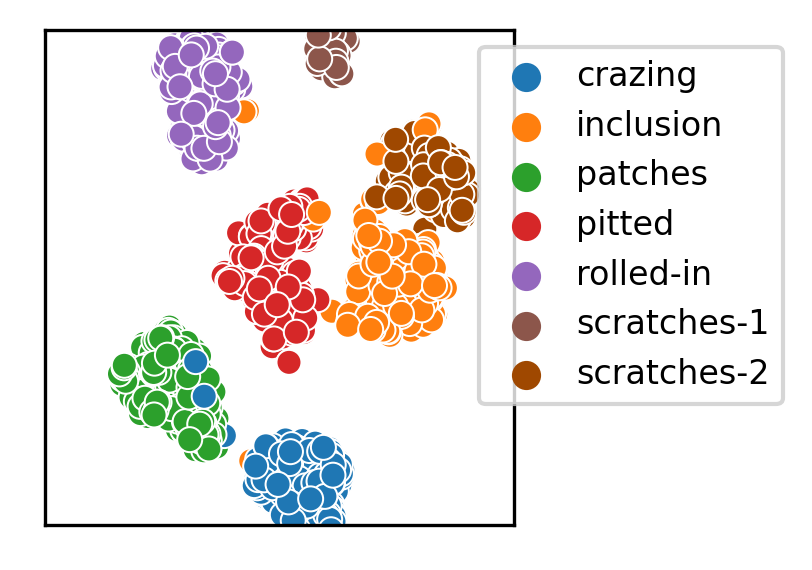

In [73]:
fig, ax  = plt.subplots(figsize=(3,2), dpi=300, facecolor='w')
sns.scatterplot(x_nw_tsne[:,0], x_nw_tsne[:,1], 
                 hue=strlabels, hue_order=sorted(np.unique(strlabels), key=lambda x: x.upper()), ax=ax, palette=list(colors))
ax.axis([-75,70,-55,55])
l1 = ax.legend(loc='upper center', ncol=1,
                bbox_to_anchor=(1.25,1), columnspacing=0.5, fontsize=(8), handletextpad=0.5)


# ax.plot(x1_Sc1[i1,0], x1_Sc1[i1,1], 'kd')
# ax.plot(x1_Sc2[i2,0], x1_Sc2[i2,1], 'ks')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

fig_path = Path('Figures')
fig.savefig(fig_path / 'tsne_kmeans_labels_std.png', bbox_inches='tight')

plt.show()

C:\Users\91800\Documents\MTP\helper\visualize.py:95: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for i in range(n)], minor=False, fontsize=fs)
C:\Users\91800\Documents\MTP\helper\visualize.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for i in range(n)], minor=False, fontsize=fs)


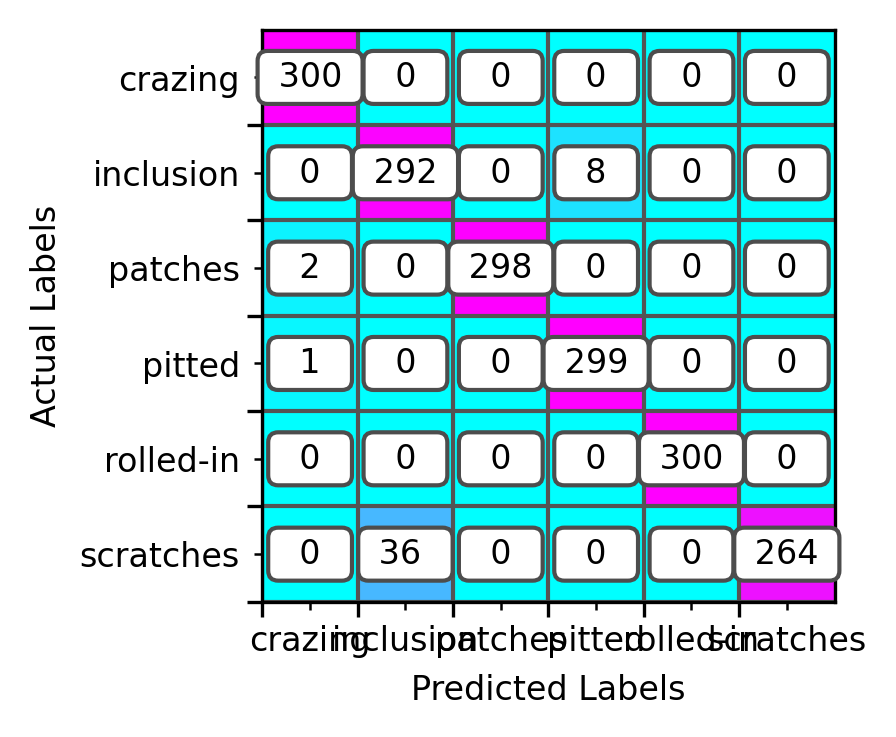

accuracy: 0.9738888888888889


In [74]:
intlabels = ct.label_matcher(kmeans.labels_, y_gt)

fig, ax = plt.subplots(figsize=(3,3), dpi=300)
CM = confusion_matrix(y_gt, intlabels)
vis.pretty_cm(CM, labelnames=le.labels_ordered, ax0=ax, fs=8, cmap='cool', )

fig.tight_layout()
fig.savefig(fig_path / 'CM_std.png', bbox_inches='tight')
plt.show()
print('accuracy: {}'.format(CM.trace()/CM.sum()))

In [75]:
print(ct.latex_report(y_gt, intlabels, le.labels_ordered))


\begin{tabular}{lcc}
	Class	& Precision	& Recall	\\  \hline 
	crazing	& 0.990 	& 1.000 	\\
	inclusion	& 0.890 	& 0.973 	\\
	patches	& 1.000 	& 0.993 	\\
	pitted	& 0.974 	& 0.997 	\\
	rolled-in	& 1.000 	& 1.000 	\\
	scratches	& 1.000 	& 0.880 	\\
\end{tabular}
